Acknowledgement: This code was initially inspired by the lab "COMP34212_Lab2b_Keras_CNN_CIFAR_2025" before undergoing significant changes.

# Setup

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, SpatialDropout2D
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Input, Add
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import backend as K


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

print('Libraries imported.')

Libraries imported.


# Data Preperation

In [ ]:



cifar100_fine_labels = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

cifar100_coarse_labels = [
    'aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables',
    'household electrical devices', 'household furniture', 'insects', 'large carnivores',
    'large man-made outdoor things', 'large natural outdoor scenes', 'large omnivores and herbivores',
    'medium-sized mammals', 'non-insect invertebrates', 'people', 'reptiles', 'small mammals',
    'trees', 'vehicles 1', 'vehicles 2'
]


fine_to_coarse_mapping = {
    0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7,
    8: 18, 9: 3, 10: 3, 11: 14, 12: 9, 13: 18, 14: 7, 15: 11,
    16: 3, 17: 9, 18: 7, 19: 11, 20: 6, 21: 11, 22: 5, 23: 10,
    24: 7, 25: 6, 26: 13, 27: 15, 28: 3, 29: 15, 30: 0, 31: 11,
    32: 1, 33: 10, 34: 12, 35: 14, 36: 16, 37: 9, 38: 11, 39: 5,
    40: 5, 41: 19, 42: 8, 43: 8, 44: 15, 45: 13, 46: 14, 47: 17,
    48: 18, 49: 10, 50: 16, 51: 4, 52: 17, 53: 4, 54: 2, 55: 0,
    56: 17, 57: 4, 58: 18, 59: 17, 60: 10, 61: 3, 62: 2, 63: 12,
    64: 12, 65: 16, 66: 12, 67: 1, 68: 9, 69: 19, 70: 2, 71: 10,
    72: 0, 73: 1, 74: 16, 75: 12, 76: 9, 77: 13, 78: 15, 79: 13,
    80: 16, 81: 18, 82: 2, 83: 4, 84: 6, 85: 19, 86: 5, 87: 5,
    88: 8, 89: 19, 90: 18, 91: 1, 92: 2, 93: 15, 94: 6, 95: 0,
    96: 17, 97: 8, 98: 14, 99: 13
}

In [ ]:

BATCH_SIZE = 256
N_EPOCH = 50
N_CLASSES = 100
N_SUPERCLASSES = 20
VERBOSE = 1
VALIDATION_SPLIT = 0.2

print('Main variables initialised.')


IMG_CHANNELS = 3
IMG_ROWS = 32
IMG_COLS = 32

print('Image variables initialisation')


Main variables initialised.
Image variables initialisation


In [ ]:

(input_X_train, output_y_train), (input_X_test, output_y_test) = cifar100.load_data(label_mode='fine')
print('input_X_train shape:', input_X_train.shape)
print(input_X_train.shape[0], 'train samples')
print(input_X_test.shape[0], 'test samples')


output_Y_train = utils.to_categorical(output_y_train, N_CLASSES)
output_Y_test = utils.to_categorical(output_y_test, N_CLASSES)


input_X_train = input_X_train.astype('float32')
input_X_test = input_X_test.astype('float32')
input_X_train /= 255
input_X_test /= 255


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
input_X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


Sample input image class: apple


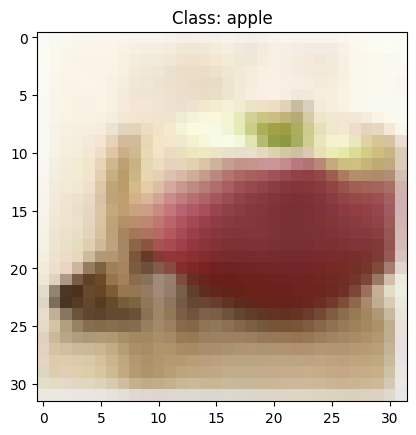

Sample input image class: boy


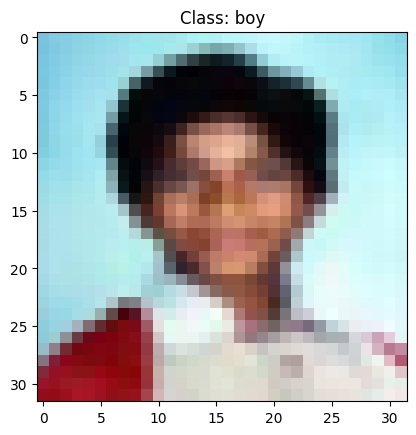

In [ ]:

Selected_Image = 2
image = input_X_train[Selected_Image]
print("Sample input image class:", cifar100_fine_labels[output_y_train[Selected_Image][0]])
plt.imshow(image)
plt.title(f"Class: {cifar100_fine_labels[output_y_train[Selected_Image][0]]}")
plt.show()

Selected_Image = 3
image = input_X_train[Selected_Image]
print("Sample input image class:", cifar100_fine_labels[output_y_train[Selected_Image][0]])
plt.imshow(image)
plt.title(f"Class: {cifar100_fine_labels[output_y_train[Selected_Image][0]]}")
plt.show()

# Training

In [ ]:
def identity_block(x, filters, dropout_rate):
    x_skip = x


    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)


    x = Add()([x, x_skip])
    x = Activation('relu')(x)
    return x


In [ ]:
def conv_block(x, filters, stride, dropout_rate):
    x_skip = x


    x = Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout2D(dropout_rate)(x)


    x_skip = Conv2D(filters, 1, strides=stride, padding='same')(x_skip)
    x_skip = BatchNormalization()(x_skip)

    x = Add()([x, x_skip])
    x = Activation('relu')(x)
    return x


In [ ]:

inputs = Input(shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS))


x = Conv2D(64, 3, strides=1, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.05)(x)




x = conv_block(x, 64, stride=1, dropout_rate=0.1)
x = identity_block(x, 64, dropout_rate=0.1)


x = conv_block(x, 128, stride=2, dropout_rate=0.2)
x = identity_block(x, 128, dropout_rate=0.2)


x = conv_block(x, 256, stride=2, dropout_rate=0.3)
x = identity_block(x, 256, dropout_rate=0.3)


x = Dropout(0.3)(x)
x = GlobalAveragePooling2D()(x)
outputs = Dense(N_CLASSES, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
class TrainingMonitor(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = K.get_value(self.model.optimizer.learning_rate)
        print(f"\nEpoch {epoch+1}")
        print(f"LR: {lr:.1e}\n")
        print(f"  Training Loss: {logs['loss']:.4f} - Training Accuracy: {logs['accuracy']:.4f}")
        print(f"  Validation Loss: {logs['val_loss']:.4f} - Validation Accuracy: {logs['val_accuracy']:.4f}")
        if logs['accuracy'] - logs['val_accuracy'] > 0.15:
            print(f"! Overfitting: {logs['accuracy']-logs['val_accuracy']:.4f} gap")



In [ ]:

OPTIM1 = RMSprop()
model.compile(loss='categorical_crossentropy', optimizer=OPTIM1, metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32, 32, 64)     │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │          4,160 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d         │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ spatial_dropout2d[0][… │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 32, 32, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 2,811,940 (10.73 MB)

 Trainable params: 2,807,332 (10.71 MB)

 Non-trainable params: 4,608 (18.00 KB)

In [ ]:

early_stop = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=8,
    restore_best_weights=True,
    start_from_epoch=10
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=6,
    min_lr=1e-5,
    mode='max',
    cooldown=2,
    verbose=1
)

In [ ]:

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
history = model.fit(
    input_X_train, output_Y_train,
    batch_size=BATCH_SIZE,
    epochs=N_EPOCH,
    validation_split=VALIDATION_SPLIT,
    verbose=VERBOSE,
    callbacks=[
        early_stop,
        checkpoint,
        TrainingMonitor(),
        reduce_lr,
    ]
)


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.0659 - loss: 4.2847
Epoch 1: val_accuracy improved from -inf to 0.00840, saving model to best_model.h5



Epoch 1
LR: 1.0e-03

  Training Loss: 3.9605 - Training Accuracy: 0.0968
  Validation Loss: 7.0682 - Validation Accuracy: 0.0084
157/157 ━━━━━━━━━━━━━━━━━━━━ 46s 132ms/step - accuracy: 0.0661 - loss: 4.2826 - val_accuracy: 0.0084 - val_loss: 7.0682 - learning_rate: 0.0010
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1762 - loss: 3.4036
Epoch 2: val_accuracy improved from 0.00840 to 0.03800, saving model to best_model.h5



Epoch 2
LR: 1.0e-03

  Training Loss: 3.2588 - Training Accuracy: 0.2019
  Validation Loss: 5.5977 - Validation Accuracy: 0.0380
! Overfitting: 0.1639 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.1764 - loss: 3.4027 - val_accuracy: 0.0380 - val_loss: 5.5977 - learning_rate: 0.0010
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2667 - loss: 2.8955
Epoch 3: val_accuracy improved from 0.03800 to 0.09450, saving model to best_model.h5



Epoch 3
LR: 1.0e-03

  Training Loss: 2.8001 - Training Accuracy: 0.2841
  Validation Loss: 4.9641 - Validation Accuracy: 0.0945
! Overfitting: 0.1896 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.2668 - loss: 2.8949 - val_accuracy: 0.0945 - val_loss: 4.9641 - learning_rate: 0.0010
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3418 - loss: 2.5121
Epoch 4: val_accuracy improved from 0.09450 to 0.24940, saving model to best_model.h5



Epoch 4
LR: 1.0e-03

  Training Loss: 2.4578 - Training Accuracy: 0.3551
  Validation Loss: 3.0677 - Validation Accuracy: 0.2494
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.3419 - loss: 2.5118 - val_accuracy: 0.2494 - val_loss: 3.0677 - learning_rate: 0.0010
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3963 - loss: 2.2415
Epoch 5: val_accuracy did not improve from 0.24940

Epoch 5
LR: 1.0e-03

  Training Loss: 2.1961 - Training Accuracy: 0.4092
  Validation Loss: 5.2133 - Validation Accuracy: 0.1045
! Overfitting: 0.3047 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.3964 - loss: 2.2412 - val_accuracy: 0.1045 - val_loss: 5.2133 - learning_rate: 0.0010
Epoch 6/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4450 - loss: 2.0254
Epoch 6: val_accuracy improved from 0.24940 to 0.28770, saving model to best_model.h5



Epoch 6
LR: 1.0e-03

  Training Loss: 1.9849 - Training Accuracy: 0.4566
  Validation Loss: 3.1576 - Validation Accuracy: 0.2877
! Overfitting: 0.1689 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.4451 - loss: 2.0249 - val_accuracy: 0.2877 - val_loss: 3.1576 - learning_rate: 0.0010
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4925 - loss: 1.8294
Epoch 7: val_accuracy improved from 0.28770 to 0.38300, saving model to best_model.h5



Epoch 7
LR: 1.0e-03

  Training Loss: 1.8155 - Training Accuracy: 0.4977
  Validation Loss: 2.4659 - Validation Accuracy: 0.3830
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.4926 - loss: 1.8293 - val_accuracy: 0.3830 - val_loss: 2.4659 - learning_rate: 0.0010
Epoch 8/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5287 - loss: 1.6855
Epoch 8: val_accuracy did not improve from 0.38300

Epoch 8
LR: 1.0e-03

  Training Loss: 1.6684 - Training Accuracy: 0.5325
  Validation Loss: 3.2201 - Validation Accuracy: 0.2801
! Overfitting: 0.2524 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5287 - loss: 1.6853 - val_accuracy: 0.2801 - val_loss: 3.2201 - learning_rate: 0.0010
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5681 - loss: 1.5355
Epoch 9: val_accuracy did not improve from 0.38300

Epoch 9
LR: 1.0e-03

  Training Loss: 1.5349 - Training Accuracy: 0.5684
  Validation Loss: 2.9247 - Validation Accuracy: 0.3374
! Overfitting: 0.2310 ga


Epoch 12
LR: 1.0e-03

  Training Loss: 1.2145 - Training Accuracy: 0.6449
  Validation Loss: 2.5204 - Validation Accuracy: 0.4024
! Overfitting: 0.2425 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6490 - loss: 1.2049 - val_accuracy: 0.4024 - val_loss: 2.5204 - learning_rate: 0.0010
Epoch 13/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6770 - loss: 1.0950
Epoch 13: val_accuracy improved from 0.40240 to 0.41910, saving model to best_model.h5



Epoch 13
LR: 1.0e-03

  Training Loss: 1.1135 - Training Accuracy: 0.6718
  Validation Loss: 2.4939 - Validation Accuracy: 0.4191
! Overfitting: 0.2527 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6770 - loss: 1.0951 - val_accuracy: 0.4191 - val_loss: 2.4939 - learning_rate: 0.0010
Epoch 14/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7016 - loss: 1.0064
Epoch 14: val_accuracy improved from 0.41910 to 0.45580, saving model to best_model.h5



Epoch 14
LR: 1.0e-03

  Training Loss: 1.0269 - Training Accuracy: 0.6952
  Validation Loss: 2.2069 - Validation Accuracy: 0.4558
! Overfitting: 0.2394 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7015 - loss: 1.0065 - val_accuracy: 0.4558 - val_loss: 2.2069 - learning_rate: 0.0010
Epoch 15/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7206 - loss: 0.9302
Epoch 15: val_accuracy did not improve from 0.45580

Epoch 15
LR: 1.0e-03

  Training Loss: 0.9422 - Training Accuracy: 0.7166
  Validation Loss: 3.1611 - Validation Accuracy: 0.3475
! Overfitting: 0.3691 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7206 - loss: 0.9303 - val_accuracy: 0.3475 - val_loss: 3.1611 - learning_rate: 0.0010
Epoch 16/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7489 - loss: 0.8351
Epoch 16: val_accuracy did not improve from 0.45580

Epoch 16
LR: 1.0e-03

  Training Loss: 0.8576 - Training Accuracy: 0.7423
  Validation Loss: 2.9815 - Validation Accuracy


Epoch 21
LR: 5.0e-04

  Training Loss: 0.3813 - Training Accuracy: 0.8904
  Validation Loss: 2.2331 - Validation Accuracy: 0.5291
! Overfitting: 0.3613 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8818 - loss: 0.4052 - val_accuracy: 0.5291 - val_loss: 2.2331 - learning_rate: 5.0000e-04
Epoch 22/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9139 - loss: 0.3071
Epoch 22: val_accuracy improved from 0.52910 to 0.57110, saving model to best_model.h5



Epoch 22
LR: 5.0e-04

  Training Loss: 0.3133 - Training Accuracy: 0.9115
  Validation Loss: 1.9301 - Validation Accuracy: 0.5711
! Overfitting: 0.3404 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9139 - loss: 0.3071 - val_accuracy: 0.5711 - val_loss: 1.9301 - learning_rate: 5.0000e-04
Epoch 23/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9291 - loss: 0.2623
Epoch 23: val_accuracy did not improve from 0.57110

Epoch 23
LR: 5.0e-04

  Training Loss: 0.2725 - Training Accuracy: 0.9251
  Validation Loss: 1.9819 - Validation Accuracy: 0.5557
! Overfitting: 0.3694 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9291 - loss: 0.2624 - val_accuracy: 0.5557 - val_loss: 1.9819 - learning_rate: 5.0000e-04
Epoch 24/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9358 - loss: 0.2373
Epoch 24: val_accuracy did not improve from 0.57110

Epoch 24
LR: 5.0e-04

  Training Loss: 0.2465 - Training Accuracy: 0.9322
  Validation Loss: 2.4190 - Validation 


Epoch 27
LR: 5.0e-04

  Training Loss: 0.1744 - Training Accuracy: 0.9528
  Validation Loss: 2.0294 - Validation Accuracy: 0.5746
! Overfitting: 0.3782 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9566 - loss: 0.1671 - val_accuracy: 0.5746 - val_loss: 2.0294 - learning_rate: 5.0000e-04
Epoch 28/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9612 - loss: 0.1534
Epoch 28: val_accuracy did not improve from 0.57460

Epoch 28
LR: 5.0e-04

  Training Loss: 0.1584 - Training Accuracy: 0.9595
  Validation Loss: 2.0345 - Validation Accuracy: 0.5727
! Overfitting: 0.3868 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9611 - loss: 0.1534 - val_accuracy: 0.5727 - val_loss: 2.0345 - learning_rate: 5.0000e-04
Epoch 29/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9666 - loss: 0.1334
Epoch 29: val_accuracy did not improve from 0.57460

Epoch 29
LR: 5.0e-04

  Training Loss: 0.1425 - Training Accuracy: 0.9635
  Validation Loss: 2.4138 - Validation 


Epoch 34
LR: 2.5e-04

  Training Loss: 0.0675 - Training Accuracy: 0.9857
  Validation Loss: 2.0228 - Validation Accuracy: 0.6021
! Overfitting: 0.3836 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9841 - loss: 0.0719 - val_accuracy: 0.6021 - val_loss: 2.0228 - learning_rate: 2.5000e-04
Epoch 35/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9896 - loss: 0.0542
Epoch 35: val_accuracy improved from 0.60210 to 0.60490, saving model to best_model.h5



Epoch 35
LR: 2.5e-04

  Training Loss: 0.0551 - Training Accuracy: 0.9893
  Validation Loss: 2.0110 - Validation Accuracy: 0.6049
! Overfitting: 0.3844 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9895 - loss: 0.0542 - val_accuracy: 0.6049 - val_loss: 2.0110 - learning_rate: 2.5000e-04
Epoch 36/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9911 - loss: 0.0488
Epoch 36: val_accuracy did not improve from 0.60490

Epoch 36
LR: 2.5e-04

  Training Loss: 0.0499 - Training Accuracy: 0.9905
  Validation Loss: 2.1946 - Validation Accuracy: 0.5961
! Overfitting: 0.3944 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9911 - loss: 0.0488 - val_accuracy: 0.5961 - val_loss: 2.1946 - learning_rate: 2.5000e-04
Epoch 37/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9919 - loss: 0.0462
Epoch 37: val_accuracy did not improve from 0.60490

Epoch 37
LR: 2.5e-04

  Training Loss: 0.0463 - Training Accuracy: 0.9916
  Validation Loss: 2.0669 - Validation 


Epoch 40
LR: 2.5e-04

  Training Loss: 0.0391 - Training Accuracy: 0.9927
  Validation Loss: 2.0933 - Validation Accuracy: 0.6138
! Overfitting: 0.3789 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9926 - loss: 0.0392 - val_accuracy: 0.6138 - val_loss: 2.0933 - learning_rate: 2.5000e-04
Epoch 41/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9928 - loss: 0.0377
Epoch 41: val_accuracy did not improve from 0.61380

Epoch 41
LR: 2.5e-04

  Training Loss: 0.0374 - Training Accuracy: 0.9930
  Validation Loss: 2.1798 - Validation Accuracy: 0.6111
! Overfitting: 0.3819 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9928 - loss: 0.0377 - val_accuracy: 0.6111 - val_loss: 2.1798 - learning_rate: 2.5000e-04
Epoch 42/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9947 - loss: 0.0330
Epoch 42: val_accuracy did not improve from 0.61380

Epoch 42
LR: 2.5e-04

  Training Loss: 0.0352 - Training Accuracy: 0.9939
  Validation Loss: 2.2097 - Validation 


Epoch 47
LR: 1.3e-04

  Training Loss: 0.0226 - Training Accuracy: 0.9963
  Validation Loss: 2.0601 - Validation Accuracy: 0.6309
! Overfitting: 0.3654 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9958 - loss: 0.0242 - val_accuracy: 0.6309 - val_loss: 2.0601 - learning_rate: 1.2500e-04
Epoch 48/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9964 - loss: 0.0212
Epoch 48: val_accuracy did not improve from 0.63090

Epoch 48
LR: 1.3e-04

  Training Loss: 0.0205 - Training Accuracy: 0.9969
  Validation Loss: 2.0933 - Validation Accuracy: 0.6260
! Overfitting: 0.3709 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9964 - loss: 0.0212 - val_accuracy: 0.6260 - val_loss: 2.0933 - learning_rate: 1.2500e-04
Epoch 49/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9975 - loss: 0.0183
Epoch 49: val_accuracy did not improve from 0.63090

Epoch 49
LR: 1.3e-04

  Training Loss: 0.0185 - Training Accuracy: 0.9974
  Validation Loss: 2.1069 - Validation 

In [ ]:

predictions = model.predict(input_X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(output_Y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


## Evaluation

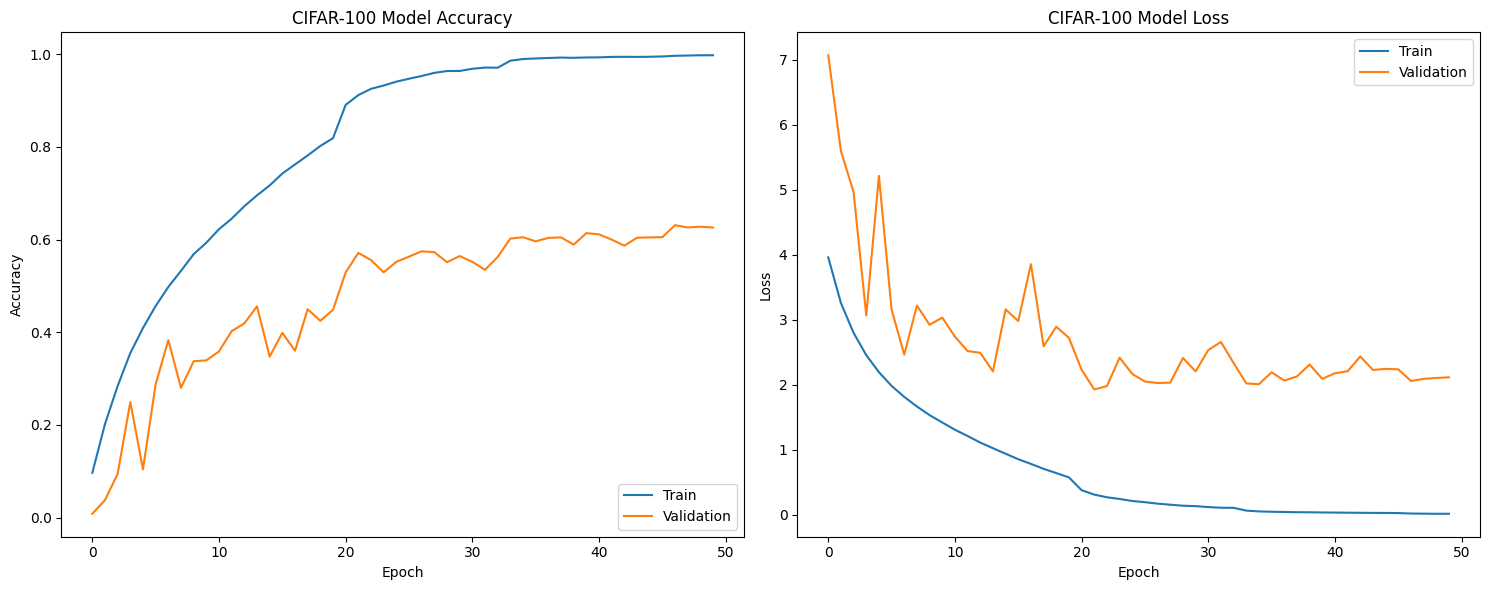

In [ ]:


plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CIFAR-100 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CIFAR-100 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:


test_loss, test_accuracy = model.evaluate(input_X_test, output_Y_test, verbose=VERBOSE)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


superclass_y_true = np.array([fine_to_coarse_mapping[y] for y in y_true])
superclass_y_pred = np.array([fine_to_coarse_mapping[y] for y in y_pred])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6322 - loss: 2.0115

Test Loss: 2.0249
Test Accuracy: 0.6285
